### Vehicle detection using following computer vision techniques.

1. HOG(Histogram of Oriented Gradients) feature extraction
2. Color space conversion and Spatial Binning
3. Histogram of color transformation
4. Sliding Window implementation for detection of vehicles in the frame

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
import glob,os

Training data(cars and not-cars) provided from GTI vehicle image database & KITTI vision benchmark has been used for the project.

In [2]:
#path = 'C:/Users/AVIK/Documents/Udacity Self Driving Cars/CarND-Vehicle-Detection-master/'
path = ''
infile_car = glob.glob(path+"vehicles/*/*.png")

vehicles = np.asarray(infile_car)    

In [3]:
notvehicles_files = []    
infile_notcars = glob.glob(path+"non-vehicles/*/*.png")
    
notvehicles = np.asarray(infile_notcars)    

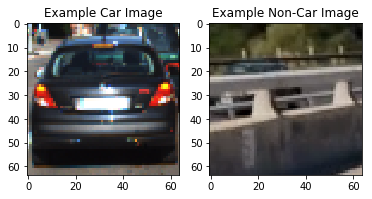

In [4]:
veh_idx = np.random.randint(len(vehicles))
notveh_idx = np.random.randint(len(notvehicles))
plt.subplot(121)
example_car_image = plt.imread(vehicles[veh_idx])
plt.imshow(example_car_image)
plt.title('Example Car Image')
plt.subplot(122)
example_noncar_image = plt.imread(notvehicles[notveh_idx])
plt.imshow(example_noncar_image)
plt.title('Example Non-Car Image')

In [5]:
print("Number of vehicle images are {}".format(len(vehicles)))
print("Number of not vehicle images are {}".format(len(notvehicles)))

Number of vehicle images are 8792
Number of not vehicle images are 8968


### Feature Engineering
The three feature components include - 

## 1. Histogram of Oriented Gradients
Three parameters determine the dimension of the feature vector and also the seperability  - 

a) Number of pixels per cell pixels_per_cell, 

b) Number of cells per block cells_per_block, and

c) Number of orientations.
    
## 2. Spatial Binning of Transformed color-space
The parameter to choose was first the color transform itself, i.e. HSV, LUV, HLS, YUV, YCrCb. Secondly the number of spatial bins of the actual image. Spatial Binning alone doesn't seem to be a reliable feature vector.

## 3. Histogram of Transformed color-space
Number of histogram bins was a parameter to chose. Although the spatial binning and the histogram approach could have chosen from different colorspaces, here I have chosen the same color space.

In [6]:
from skimage.feature import hog

def convert_color(img, convTo='RGB'):
    if convTo == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif convTo == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif convTo == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif convTo == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif convTo == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = img
    return feature_image
  
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
                        
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


### Optimal Parameters
Following are the parameters that were tweaked to find an optimal classifier - 

a) Number of pixels per cell pixels_per_cell - 16, 

b) Number of cells per block cells_per_block - 2

c) Number of orientations - 15

d) Spatial bins - (32,32)

e) Histogram bins - 32

f) Colorspace - 'YUV'

By brute-force method the parameters were searched to find the one that provided the optimal classifier. 'YUV' colorspace was found to give the least false alarm, in the test image #5 was quite challenging due to shadows where other colorspaces had issues with false alarm. Eventually 'YUV' and 'YCrCb' colorspace was chosen to have minimal false alarm but on the project video 'YCrCb' generated many more false alarms. The other hyper-parameter to tweak was the C parameter of the Linear SVM model to achieve 98.5% + accuracy. Additionally another consideration was paid to the time taken to generate a model, this somehow had an effect (along with bounding boxes chosen) on the inference time causing the detection video to take very very long. In general low C values generated same accuracy models rather quickly hence was prefered.

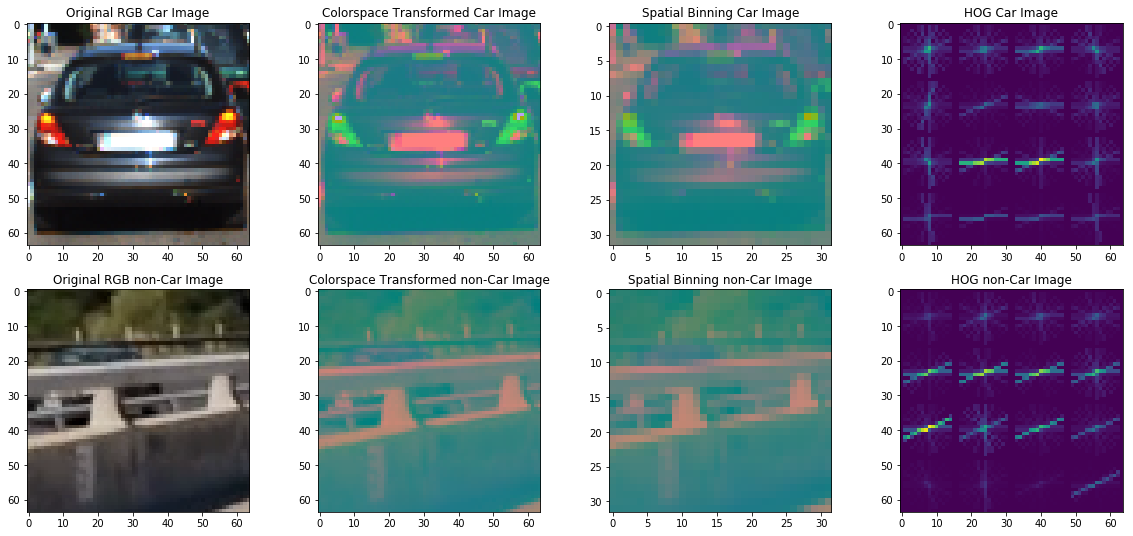

In [7]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_feat=True
hist_feat=True
hog_feat=True
spatial_size = (32,32)
hist_bins = 64

car_image = convert_color(example_car_image, colorspace) 
noncar_image = convert_color(example_noncar_image, colorspace)

spatial_feat_car = bin_spatial(car_image, size=spatial_size)
spatial_feat_car = np.reshape(spatial_feat_car,(spatial_size[0],spatial_size[1],3))
spatial_feat_noncar = bin_spatial(noncar_image, size=spatial_size)
spatial_feat_noncar = np.reshape(spatial_feat_noncar,(spatial_size[0],spatial_size[1],3))

hist_feat_car = color_hist(car_image, nbins=hist_bins)
hist_feat_noncar = color_hist(example_noncar_image, nbins=hist_bins)

car_ch1 = car_image[:,:,0]
noncar_ch1 = noncar_image[:,:,0]

car_hog_feature, car_hog_image = get_hog_features(car_ch1,
                                        orient, pix_per_cell, cell_per_block,
                                        vis=True, feature_vec=True)

noncar_hog_feature, noncar_hog_image = get_hog_features(noncar_ch1,
                                        orient, pix_per_cell, cell_per_block,
                                        vis=True, feature_vec=True)

f, axs = plt.subplots(2, 4, figsize=(20, 9))
axs = axs.ravel()
axs[0].imshow(example_car_image)
axs[0].set_title('Original RGB Car Image')
axs[1].imshow(car_image)
axs[1].set_title('Colorspace Transformed Car Image')
axs[2].imshow(spatial_feat_car)
axs[2].set_title('Spatial Binning Car Image')
axs[3].imshow(car_hog_image)
axs[3].set_title('HOG Car Image')
axs[4].imshow(example_noncar_image)
axs[4].set_title('Original RGB non-Car Image')
axs[5].imshow(noncar_image)
axs[5].set_title('Colorspace Transformed non-Car Image')
axs[6].imshow(spatial_feat_noncar)
axs[6].set_title('Spatial Binning non-Car Image')
axs[7].imshow(noncar_hog_image)
axs[7].set_title('HOG non-Car Image')

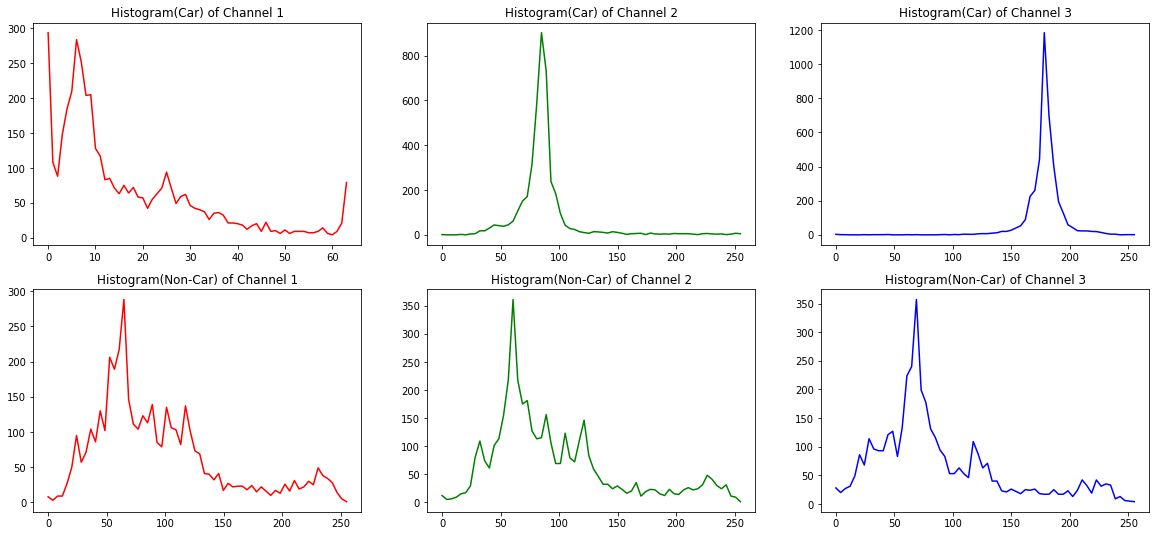

In [8]:
f, axs = plt.subplots(2, 3, figsize=(20, 9))
axs = axs.ravel()

bins = np.linspace(0,255,hist_bins)
axs[0].plot(hist_feat_car[0:hist_bins],'red')
axs[0].set_title('Histogram(Car) of Channel 1')
axs[1].plot(bins, hist_feat_car[hist_bins:2*hist_bins],'green')
axs[1].set_title('Histogram(Car) of Channel 2')
axs[2].plot(bins, hist_feat_car[2*hist_bins:3*hist_bins],'blue')
axs[2].set_title('Histogram(Car) of Channel 3')
axs[3].plot(bins, hist_feat_noncar[0:hist_bins],'red')
axs[3].set_title('Histogram(Non-Car) of Channel 1')
axs[4].plot(bins, hist_feat_noncar[hist_bins:2*hist_bins],'green')
axs[4].set_title('Histogram(Non-Car) of Channel 2')
axs[5].plot(bins, hist_feat_noncar[2*hist_bins:3*hist_bins],'blue')
axs[5].set_title('Histogram(Non-Car) of Channel 3')

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace, spatial_size = (32, 32),
                        hist_bins=32, orient=15, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image = np.squeeze(imgs[idx,:,:,:])
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            feature_image = convert_color(image, convTo=cspace)
        else: 
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


### Notes
Not all the training examples were taken about 2500 of either class was found to be sufficient. This number was obtained rather empiracally. The other factor was taking 4000+ examples started deterioting the model performance on project video perhaps due to over-fitting.  

In [10]:
import random
from sklearn.model_selection import train_test_split

examples_to_sample = 2500

vehicles_idx = random.sample(range(1, len(vehicles)), examples_to_sample)
cars = vehicles[vehicles_idx]
notvehicles_idx = random.sample(range(1, len(notvehicles)), examples_to_sample)
notcars = notvehicles[notvehicles_idx]

car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 43
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)



In [11]:
print('Num of training samples {}'.format(len(y_train)))
print('Num of test samples {}'.format(len(y_test)))

Num of training samples 4000
Num of test samples 1000


### Notes
GridSearchCV took extremely long to execute, thus limited to linear SVMs with only C parameter tuning manually.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report
import time

# Set the parameters by cross-validation
#tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e4],
#                     'C': [1, 10]},
#                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

t_start = time.time()
# Use optimal model fitting
svc = LinearSVC(C = 0.001)
clf = svc.fit(X_train, y_train)
t_stop = time.time()

print("Time to find a model {} sec".format(t_stop-t_start))

#clf = GridSearchCV(SVC(), tuned_parameters, cv=5)
#clf.fit(X_train, y_train)

print("Test classification accuracy - {}%".format(clf.score(X_test, y_test)*100))

#y_true, y_pred = y_test, clf.predict(X_test)
   

Using: 15 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4788
Time to find a model 2.92665433883667 sec
Test classification accuracy - 98.4%


In [13]:
import pickle
filename = 'saved_optimal_SVM_model'
pickle.dump(clf, open(filename,'wb'))
filename = 'saved_X_scaler'
pickle.dump(X_scaler, open(filename,'wb'))

In [14]:
feature_params = {'colorspace' : colorspace, 'orient' : orient, 'pix_per_cell' : pix_per_cell, 'cell_per_block' : cell_per_block,
            'hog_channel' : hog_channel, 'spatial_feat' : spatial_feat, 'hist_feat' : hist_feat, 'hog_feat' : hog_feat}

with open('saved_feature_params.pickle', 'wb') as handle:
    pickle.dump(feature_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
